In [1]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Definición del Modelo

In [2]:
class Lobo(Agent):
    # Agentes que se comen a las ovejas.
    def __init__(self, unique_id, pos,e,model):
        # la clase agente guarda los ids y los enlaza con el modelo 
        super().__init__(unique_id,model)
        # lobos tienen energia, una posicion y una probabilidad de reproducirse
        self.energia = e 
        self.pos = pos
    
    def move(self):
        # get_neighbourhood es utilidad de mesa pa devolver los vecinos
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=False,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        
    def step(self):
        self.move()
         
        # comerse alguna oveja que este en su grilla 
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        sheep = [obj for obj in cellmates if isinstance(obj, Oveja)]
        if len(sheep)>0: 
            victima = self.random.choice(sheep)
            self.model.grid._remove_agent(self.pos, victima)
            self.model.schedule.remove(victima)
            self.energia += 10
            
        #si no tengo energia, muero 
        self.energia -= 1
        if self.energia < 1: 
            self.model.grid._remove_agent(self.pos, self)
            self.model.schedule.remove(self)
            return

In [3]:
class Oveja(Agent):
    def __init__(self, unique_id,pos,e,prob_rep, model):
        super().__init__(unique_id, model)
        self.pos = pos
        self.energia = e 
        self.prob_rep = prob_rep

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=False,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        
    def step(self):
        self.move()
        
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        pasto = [obj for obj in cellmates if isinstance(obj, Pasto)]
        if len(pasto)>0: 
            comida = self.random.choice(pasto)
            self.model.grid._remove_agent(self.pos, comida)
            self.model.schedule.remove(comida)
            self.energia += 10
            
        #tener hijos
        if self.model.random.randint(1,10) < self.prob_rep:  #probabilidad de reproducirse 
            self.energia /= 2
            hija = Oveja(self.model.next_id(),self.pos,self.energia,self.prob_rep,self.model)
            self.model.grid.place_agent(hija, hija.pos)
            self.model.schedule.add(hija)
            
        self.energia -= 1
        if self.energia < 1: 
            self.model.grid._remove_agent(self.pos, self)
            self.model.schedule.remove(self)
            return

In [4]:
class Pasto(Agent):
    def __init__(self,unique_id,pos,model):
        super().__init__(unique_id,model)
        self.pos = pos

In [5]:
class Lobooveja(Model):
    def __init__(self, N, M, O, width, height,prob_lobos,prob_pasto,p_rep_o):
        self.num_lobos = N
        self.num_ovejas = M
        self.num_pastos = O
        self.prob_lobos = prob_lobos
        self.prob_pasto = prob_pasto
        self.p_rep_o = p_rep_o
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.current_id = 0
        
        # Crear lobos
        for i in range(self.num_lobos):
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            l = Lobo(self.next_id(),(x,y),15,self) # 15 es la energía 
            self.schedule.add(l)
            # Add the agent to a random grid cell
            self.grid.place_agent(l, (x, y))
            
        # Crear ovejas
        for i in range(self.num_ovejas):
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            o = Oveja(self.next_id(),(x,y),15,self.p_rep_o,self) # 15 es la energía
            self.schedule.add(o)
            # Add the agent to a random grid cell
            self.grid.place_agent(o, (x, y)) 
    
        # Crear pasto
        for i in range(self.num_pastos):
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            p = Pasto(self.next_id(),(x,y),self)
            self.schedule.add(p)
            self.grid.place_agent(p, (x, y))
            
    def step(self):
        self.schedule.step()
  
    
    def create(self):
        if np.random.randint(1,10) < self.prob_lobos:
            for i in range(3):
                x = self.random.randrange(self.grid.width)
                y = self.random.randrange(self.grid.height)
                l = Lobo(self.next_id(),(x,y),15,self)
                self.schedule.add(l)
                self.grid.place_agent(l, (x, y))
        
        if np.random.randint(1,10) < self.prob_pasto:
            for i in range(5):
                x = self.random.randrange(self.grid.width)
                y = self.random.randrange(self.grid.height)
                p = Pasto(self.next_id(),(x,y),self)
                self.schedule.add(p)   
                self.grid.place_agent(p, (x, y))

# Simulación 1 vez

In [29]:
T = 400 #horizonte temporal
N = 30 # número de lobos
M = 10 # número de ovejas 
O = 200 #pasto

#tamaño de la grilla
width = 10  
height = 10 

ovejas = []
lobos = []

for j in range(100): #j modelos distintos 
    ovejas.append([])
    lobos.append([])
    model = Lobooveja(N,M,O,width, height,1,6,5)
    for t in range(T):
        model.step()
        model.create()
        ovejas[j].append(0)
        lobos[j].append(0)
        for a in model.schedule.agents:
            if isinstance(a,Oveja): 
                ovejas[j][t]+=1
            elif isinstance(a,Lobo):
                lobos[j][t]+=1
                                
        if (ovejas[j][t]>1000) or (lobos[j][t]>1000):
                break
                
    if len(ovejas[j])<200: #extiende listas que fueron cortadas
        ovejas[j].extend(list(np.nan * np.array(range(200 - len(ovejas[j])))))
           # print(i,j,len(ovejas1[i][j]))
                
    if len(lobos[j])<200: #extiende listas que fueron cortadas
        lobos[j].extend(list(np.nan * np.array(range(200 - len(lobos[j])))))

In [30]:
#Resultados promedios

lobos = np.array(lobos)
ovejas = np.array(ovejas)
    
av_lobos = np.nanmean(lobos,axis=0)
    
av_ovejas = np.nanmean(ovejas,axis=0)

#nan counting


number_nan = []


for t in range(T):
    counter = 0
    for j in range(100):
        if np.isnan(ovejas[j][t]):
            counter += 1

    number_nan.append(counter)  

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

No handles with labels found to put in legend.


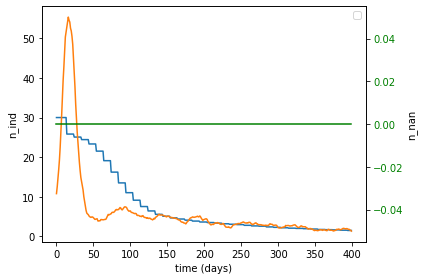

In [32]:
#Plots

fig, ax1 = plt.subplots()

ax1.set_xlabel('time (days)')
ax1.set_ylabel('n_ind')
ax1.plot(av_lobos, label = 'ovejas')
ax1.plot(av_ovejas, label = 'lobos')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

ax2.set_xlabel('time (days)')
ax2.set_ylabel('n_nan')
ax2.plot(number_nan, color = 'g')
ax2.tick_params(axis='y', labelcolor = 'g')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend()
plt.show()
plt.close()

# Sensibiidad

1. Probabilidad de que aparezca un Lobo
2. Probabilidad de Rep de Oveja
3. Proporción de lobos/ovejas

1. Probabilidad de que aparezca un Lobo

In [10]:
T = 400 #horizonte temporal
N = 30 # número de lobos
M = 10 # número de ovejas 
O = 200 #pasto

#tamaño de la grilla
width = 10  
height = 10 

#parámetros

P_lobos = np.array(range(0,100,5))/10
prob_pasto = 6
p_rep_o = 5

ovejas1 = []
lobos1 = []


for i in range(len(P_lobos)):
    print(i)
    ovejas1.append([])
    lobos1.append([])
    for j in range(100): #j modelos distintos 
        ovejas1[i].append([])
        lobos1[i].append([])
        model = Lobooveja(N,M,O,width, height,P_lobos[i],prob_pasto,p_rep_o)
        for t in range(T):
            model.step()
            model.create()
            ovejas1[i][j].append(0)
            lobos1[i][j].append(0)
            for a in model.schedule.agents:
                if isinstance(a,Oveja): 
                    ovejas1[i][j][t]+=1
                elif isinstance(a,Lobo):
                    lobos1[i][j][t]+=1

            if (ovejas1[i][j][t]>1000) or (lobos1[i][j][t]>1000):
                    break

        if len(ovejas1[i][j])<T: #extiende listas que fueron cortadas
            ovejas1[i][j].extend(list(np.nan * np.array(range(T - len(ovejas1[i][j])))))
               # print(i,j,len(ovejas1[i][j]))

        if len(lobos1[i][j])<T: #extiende listas que fueron cortadas
            lobos1[i][j].extend(list(np.nan * np.array(range(T - len(lobos1[i][j])))))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [11]:
#Resultados promedios

lobos = []
ovejas = []

for i in range(len(P_lobos)):
    lobos.append([])
    ovejas.append([])
    
    lobos_i = np.array(lobos1[i])
    ovejas_i = np.array(ovejas1[i])
    
    av_lobos_i = np.nanmean(lobos_i,axis=0)
    lobos[i]=av_lobos_i
    
    av_ovejas_i = np.nanmean(ovejas_i,axis=0)
    ovejas[i]=av_ovejas_i


#contador nan 

number_nan = []

for i in range(len(P_lobos)):
    number_nan.append([])
    for t in range(T):
        counter = 0
        for j in range(100):
            if np.isnan(ovejas1[i][j][t]):
                counter += 1
                
        number_nan[i].append(counter)    

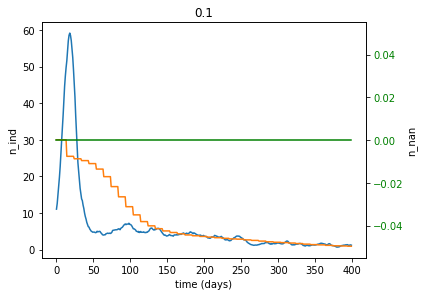

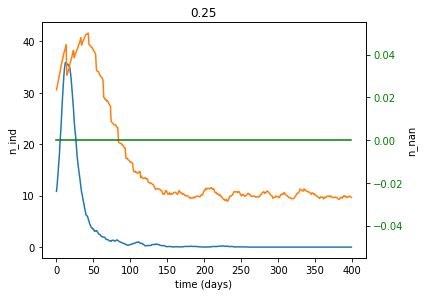

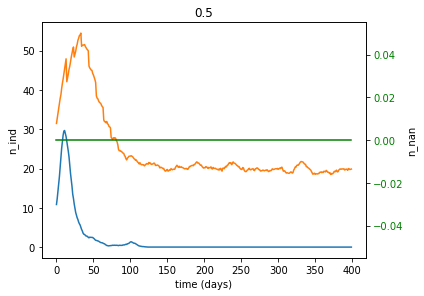

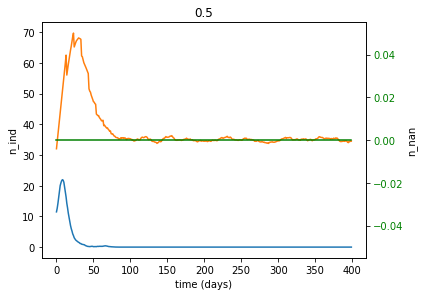

In [12]:
#GRÁFICOS

fig, ax1 = plt.subplots()

ax1.set_xlabel('time (days)')
ax1.set_ylabel('n_ind')
ax1.plot(ovejas[2], label = 'ovejas')
ax1.plot(lobos[2], label = 'lobos')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

ax2.set_xlabel('time (days)')
ax2.set_ylabel('n_nan')
ax2.plot(number_nan[2], color = 'g')
ax2.tick_params(axis='y', labelcolor = 'g')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('0.1')
plt.show()
plt.close()

#---------------------------------------------------------------------------------------------------------------

fig, ax1 = plt.subplots()

ax1.set_xlabel('time (days)')
ax1.set_ylabel('n_ind')
ax1.plot(ovejas[5], label = 'ovejas')
ax1.plot(lobos[5], label = 'lobos')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

ax2.set_xlabel('time (days)')
ax2.set_ylabel('n_nan')
ax2.plot(number_nan[5], color = 'g')
ax2.tick_params(axis='y', labelcolor = 'g')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('0.25')
plt.show()
plt.close()


#---------------------------------------------------------------------------------------------------------------


fig, ax1 = plt.subplots()

ax1.set_xlabel('time (days)')
ax1.set_ylabel('n_ind')
ax1.plot(ovejas[10], label = 'ovejas')
ax1.plot(lobos[10], label = 'lobos')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

ax2.set_xlabel('time (days)')
ax2.set_ylabel('n_nan')
ax2.plot(number_nan[10], color = 'g')
ax2.tick_params(axis='y', labelcolor = 'g')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('0.5')
plt.show()
plt.close()


#---------------------------------------------------------------------------------------------------------------


fig, ax1 = plt.subplots()

ax1.set_xlabel('time (days)')
ax1.set_ylabel('n_ind')
ax1.plot(ovejas[15], label = 'ovejas')
ax1.plot(lobos[15], label = 'lobos')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

ax2.set_xlabel('time (days)')
ax2.set_ylabel('n_nan')
ax2.plot(number_nan[15], color = 'g')
ax2.tick_params(axis='y', labelcolor = 'g')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('0.5')
plt.show()
plt.close()

2. Probabilidad de Rep de Oveja

In [6]:
T = 400 #horizonte temporal
N = 30 # número de lobos
M = 10 # número de ovejas 
O = 200 #pasto

#tamaño de la grilla
width = 10  
height = 10 

#parámetros

P_ovejas = np.array(range(0,100,5))/10
prob_pasto = 6
p_lobos = 1

ovejas1 = []
lobos1 = []


for i in range(len(P_ovejas)):
    print(i)
    ovejas1.append([])
    lobos1.append([])
    for j in range(100): #j modelos distintos 
        ovejas1[i].append([])
        lobos1[i].append([])
        model = Lobooveja(N,M,O,width, height,p_lobos,prob_pasto,P_ovejas[i])
        for t in range(T):
            model.step()
            model.create()
            ovejas1[i][j].append(0)
            lobos1[i][j].append(0)
            for a in model.schedule.agents:
                if isinstance(a,Oveja): 
                    ovejas1[i][j][t]+=1
                elif isinstance(a,Lobo):
                    lobos1[i][j][t]+=1

            if (ovejas1[i][j][t]>1000) or (lobos1[i][j][t]>1000):
                    break

        if len(ovejas1[i][j])<T: #extiende listas que fueron cortadas
            ovejas1[i][j].extend(list(np.nan * np.array(range(T - len(ovejas1[i][j])))))
               # print(i,j,len(ovejas1[i][j]))

        if len(lobos1[i][j])<T: #extiende listas que fueron cortadas
            lobos1[i][j].extend(list(np.nan * np.array(range(T - len(lobos1[i][j])))))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [8]:
#Resultados promedios

lobos = []
ovejas = []

for i in range(len(P_ovejas)):
    lobos.append([])
    ovejas.append([])
    
    lobos_i = np.array(lobos1[i])
    ovejas_i = np.array(ovejas1[i])
    
    av_lobos_i = np.nanmean(lobos_i,axis=0)
    lobos[i]=av_lobos_i
    
    av_ovejas_i = np.nanmean(ovejas_i,axis=0)
    ovejas[i]=av_ovejas_i


#contador nan 

number_nan = []

for i in range(len(P_ovejas)):
    number_nan.append([])
    for t in range(T):
        counter = 0
        for j in range(100):
            if np.isnan(ovejas1[i][j][t]):
                counter += 1
                
        number_nan[i].append(counter)    

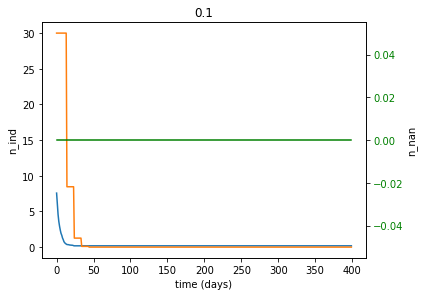

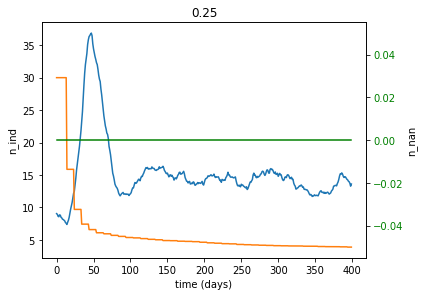

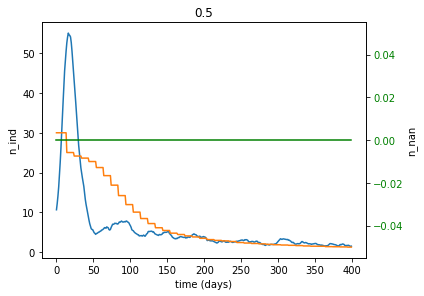

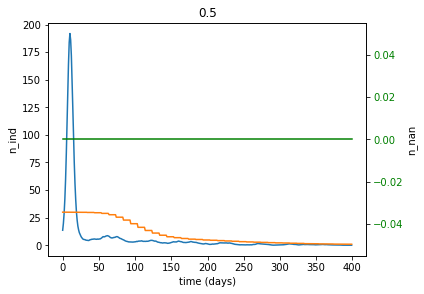

In [9]:
#GRÁFICOS

fig, ax1 = plt.subplots()

ax1.set_xlabel('time (days)')
ax1.set_ylabel('n_ind')
ax1.plot(ovejas[2], label = 'ovejas')
ax1.plot(lobos[2], label = 'lobos')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

ax2.set_xlabel('time (days)')
ax2.set_ylabel('n_nan')
ax2.plot(number_nan[2], color = 'g')
ax2.tick_params(axis='y', labelcolor = 'g')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('0.1')
plt.show()
plt.close()

#---------------------------------------------------------------------------------------------------------------

fig, ax1 = plt.subplots()

ax1.set_xlabel('time (days)')
ax1.set_ylabel('n_ind')
ax1.plot(ovejas[5], label = 'ovejas')
ax1.plot(lobos[5], label = 'lobos')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

ax2.set_xlabel('time (days)')
ax2.set_ylabel('n_nan')
ax2.plot(number_nan[5], color = 'g')
ax2.tick_params(axis='y', labelcolor = 'g')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('0.25')
plt.show()
plt.close()


#---------------------------------------------------------------------------------------------------------------


fig, ax1 = plt.subplots()

ax1.set_xlabel('time (days)')
ax1.set_ylabel('n_ind')
ax1.plot(ovejas[10], label = 'ovejas')
ax1.plot(lobos[10], label = 'lobos')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

ax2.set_xlabel('time (days)')
ax2.set_ylabel('n_nan')
ax2.plot(number_nan[10], color = 'g')
ax2.tick_params(axis='y', labelcolor = 'g')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('0.5')
plt.show()
plt.close()


#---------------------------------------------------------------------------------------------------------------


fig, ax1 = plt.subplots()

ax1.set_xlabel('time (days)')
ax1.set_ylabel('n_ind')
ax1.plot(ovejas[15], label = 'ovejas')
ax1.plot(lobos[15], label = 'lobos')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

ax2.set_xlabel('time (days)')
ax2.set_ylabel('n_nan')
ax2.plot(number_nan[15], color = 'g')
ax2.tick_params(axis='y', labelcolor = 'g')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('0.75')
plt.show()
plt.close()

3. Proporción de lobos/ovejas

In [6]:
T = 400 #horizonte temporal
N = np.array(range(1,41)) # número de lobos
M = np.sort(np.array(range(1,41)))[::-1] # número de ovejas 
O = 200 #pasto

#tamaño de la grilla
width = 10  
height = 10 

#parámetros

prob_ovejas = 5
prob_pasto = 6
p_lobos = 1

ovejas1 = []
lobos1 = []


for i in range(len(N)):
    print(i)
    ovejas1.append([])
    lobos1.append([])
    for j in range(100): #j modelos distintos 
        ovejas1[i].append([])
        lobos1[i].append([])
        model = Lobooveja(N[i],M[i],O,width, height,p_lobos,prob_pasto,prob_ovejas)
        for t in range(T):
            model.step()
            model.create()
            ovejas1[i][j].append(0)
            lobos1[i][j].append(0)
            for a in model.schedule.agents:
                if isinstance(a,Oveja): 
                    ovejas1[i][j][t]+=1
                elif isinstance(a,Lobo):
                    lobos1[i][j][t]+=1

            if (ovejas1[i][j][t]>1000) or (lobos1[i][j][t]>1000):
                    break

        if len(ovejas1[i][j])<T: #extiende listas que fueron cortadas
            ovejas1[i][j].extend(list(np.nan * np.array(range(T - len(ovejas1[i][j])))))
               # print(i,j,len(ovejas1[i][j]))

        if len(lobos1[i][j])<T: #extiende listas que fueron cortadas
            lobos1[i][j].extend(list(np.nan * np.array(range(T - len(lobos1[i][j])))))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [7]:
#Resultados promedios

lobos = []
ovejas = []

for i in range(len(N)):
    lobos.append([])
    ovejas.append([])
    
    lobos_i = np.array(lobos1[i])
    ovejas_i = np.array(ovejas1[i])
    
    av_lobos_i = np.nanmean(lobos_i,axis=0)
    lobos[i]=av_lobos_i
    
    av_ovejas_i = np.nanmean(ovejas_i,axis=0)
    ovejas[i]=av_ovejas_i


#contador nan 

number_nan = []

for i in range(len(N)):
    number_nan.append([])
    for t in range(T):
        counter = 0
        for j in range(100):
            if np.isnan(ovejas1[i][j][t]):
                counter += 1
                
        number_nan[i].append(counter)    

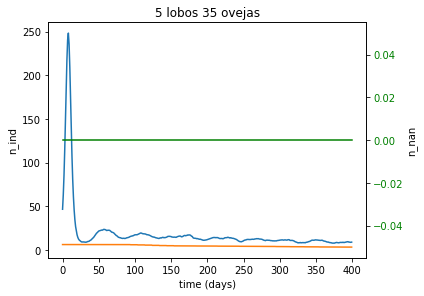

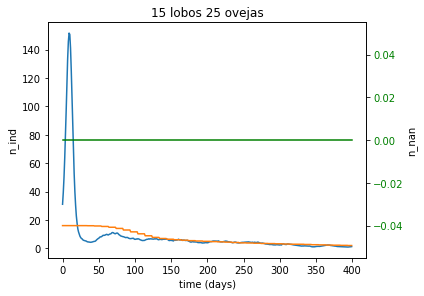

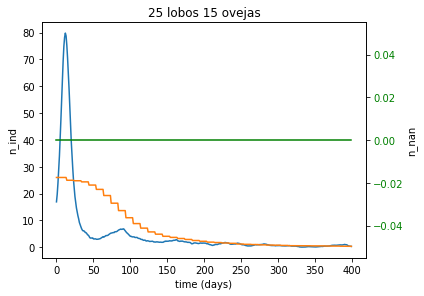

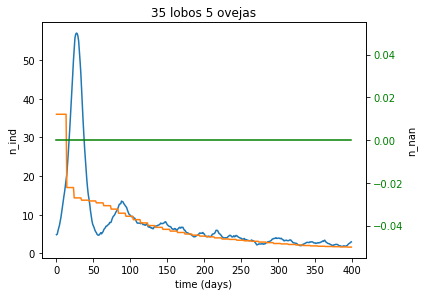

In [8]:
#GRÁFICOS

fig, ax1 = plt.subplots()

ax1.set_xlabel('time (days)')
ax1.set_ylabel('n_ind')
ax1.plot(ovejas[5], label = 'ovejas')
ax1.plot(lobos[5], label = 'lobos')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

ax2.set_xlabel('time (days)')
ax2.set_ylabel('n_nan')
ax2.plot(number_nan[5], color = 'g')
ax2.tick_params(axis='y', labelcolor = 'g')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('5 lobos 35 ovejas')
plt.show()
plt.close()

#---------------------------------------------------------------------------------------------------------------

fig, ax1 = plt.subplots()

ax1.set_xlabel('time (days)')
ax1.set_ylabel('n_ind')
ax1.plot(ovejas[15], label = 'ovejas')
ax1.plot(lobos[15], label = 'lobos')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

ax2.set_xlabel('time (days)')
ax2.set_ylabel('n_nan')
ax2.plot(number_nan[15], color = 'g')
ax2.tick_params(axis='y', labelcolor = 'g')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('15 lobos 25 ovejas')
plt.show()
plt.close()


#---------------------------------------------------------------------------------------------------------------


fig, ax1 = plt.subplots()

ax1.set_xlabel('time (days)')
ax1.set_ylabel('n_ind')
ax1.plot(ovejas[25], label = 'ovejas')
ax1.plot(lobos[25], label = 'lobos')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

ax2.set_xlabel('time (days)')
ax2.set_ylabel('n_nan')
ax2.plot(number_nan[25], color = 'g')
ax2.tick_params(axis='y', labelcolor = 'g')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('25 lobos 15 ovejas')
plt.show()
plt.close()


#---------------------------------------------------------------------------------------------------------------


fig, ax1 = plt.subplots()

ax1.set_xlabel('time (days)')
ax1.set_ylabel('n_ind')
ax1.plot(ovejas[35], label = 'ovejas')
ax1.plot(lobos[35], label = 'lobos')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

ax2.set_xlabel('time (days)')
ax2.set_ylabel('n_nan')
ax2.plot(number_nan[35], color = 'g')
ax2.tick_params(axis='y', labelcolor = 'g')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('35 lobos 5 ovejas')
plt.show()
plt.close()
